The original model with less sensors

In [1]:
#datasets without day 0 
import pandas as pd
Imputed_test_set = pd.read_csv("Data/Imputed_test_set.csv")
Imputed_train_set = pd.read_csv("Data/Imputed_train_set.csv")
Imputed_train_set_up = pd.read_csv("Data/Imputed_train_set_up.csv")
Imputed_validation_set = pd.read_csv("Data/Imputed_validation_set.csv")


TRAIN SET

In [2]:
#Extracting x and y-values as model input. Sequential sensordata is stored in a 3d matrix of 22 days per 5 features per 365 cows.
import numpy as np
import pandas as pd
#extracting all unique combinations of cow and calving moment 
Unique_Calvings = Imputed_train_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates() 

#define sensors
feature_names = ["WalkingTimeMinutesPerDay", "EatingTimeMinutesPerDay", "LyingTimeMinutesPerDay", "StandingTimeMinutesPerDay", "RuminationTimeMinutesPerDay"]

#create empty lists per feature to store variables
AnimalEartag_list = [] 
PaperRecordedCalvingDate_list = []
CalciumValue_list = []
Calciumcluster_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardes_list = np.zeros((365,21,5)) #define matrix size for sequential features
j = 0

#itterating through the dataset in order to extract x and y for each cow 
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings.iterrows():
    filter1 = Imputed_train_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_train_set['PaperRecordedCalvingDate']
    df_calving = Imputed_train_set[filter1 & filter2]
    Loco = df_calving['FirstLocomotionScore'].max()
    BCS =  df_calving['FirstBCSScore'].max()
    cacluster = df_calving['Calciumcluster'].iloc[-1] 
    ca = df_calving['Cut_Off'].iloc[-1]
    sw = df_calving[feature_names]
  
    #convert to numpy
    sw_numpy = np.array(sw)
    #add to list 
    AnimalEartag_list.append(AnimalEartag)
    PaperRecordedCalvingDate_list.append(PaperRecordedCalvingDate)
    CalciumValue_list.append(ca)
    Calciumcluster_list.append(cacluster)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
   
    SensorWaardes_list[j] = sw_numpy
    j = j + 1
 
#convert to numpy arrays
x_train = np.array(SensorWaardes_list)
y_train = np.asarray(Calciumcluster_list)
y_train2 = np.asarray(CalciumValue_list) #alternatieve y-waardes op basis van een calciumcut-off
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
x_static = np.stack((x_BCS, x_Loco), axis = 1)

ONEHOTENCODER

In [3]:
#Calvingseason and parity are cathegorial variables, however the models functions on numerical variables only, therefore the variables are converted into binairy variables using the sklearn onehotencoder. Each category gets its own colummn and the column of the category that is true gets a one, all other get a zero.     
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
#extract value for each cow
static = Imputed_train_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
#convert to numpy
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
#define labelencoder
labelEnc = LabelEncoder()
#fit and apply
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine season, parity and day of measurement into one numpy array 
x_static_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])

c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
#BCS and Locomotion score was not measured for every cow, therefore some cows have a null value. The null values are replaced by the value that is most frequent in that colummn. 
import numpy as np
from sklearn.impute import SimpleImputer
imp_freq = SimpleImputer(missing_values=0.0, strategy='most_frequent')
imp_freq.fit(x_static)
x_static = imp_freq.transform(x_static)
#all static features are added up into one numpy array 
x_Static = np.column_stack([x_static, season_encoded, parity_encoded, CalciumDaysInMilk]) 

Upsampled trainset 

In [5]:
#Since this train set is upsampled, it is impossible to filter on animal eartag and paperrecordedcalvingdate (some cows of cathegory 1 are duplicated and therefore no longer unique) therefore a new column was introduced while performing upsampling called 'Samplenumber' In order to extract an x and an y per sample, an itteration is performed based on samplenumber. 
Unique_Calvings = Imputed_train_set_up['SampleNumber'].drop_duplicates()


#creating empty lists, pay attention to the increased matrix size and the addition of a list for samplenumber
SampleNumber_list = []
CalciumValue_list = []
Calciumcluster_list = []
SensorWaardes_list = np.zeros((534,21,5)) #534 cows, 21 days, 5 sensors
BCS_lijst = []
Loco_lijst = []
j = 0
for s in range(len(Unique_Calvings)):
    filter = Imputed_train_set_up['SampleNumber'] == s
    df_calving = Imputed_train_set_up[filter]
    Loco = df_calving['FirstLocomotionScore'].max()
    BCS =  df_calving['FirstBCSScore'].max()
    i = 1
    cacluster = df_calving['Calciumcluster'].iloc[-i]
    ca = df_calving['Cut_Off'].iloc[-i]
    i = i + 1 #prevents infinite loop
  
    sw = df_calving[feature_names]
  
    #convert to numpy
    sw_numpy = np.array(sw)
    #add to list
    SampleNumber_list.append(s)
    CalciumValue_list.append(ca)
    Calciumcluster_list.append(cacluster)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
  
    SensorWaardes_list[j] = sw_numpy
    j = j + 1

#transform to numpy array
x_train_up = np.array(SensorWaardes_list)
y_train_up = np.asarray(Calciumcluster_list)
y_train2_up =np.asarray(CalciumValue_list)
x_BCS_up = np.asarray(BCS_lijst) #BCS end dry period 
x_Loco_up = np.asarray(Loco_lijst) #locomotionscore end dry period
x_static_up = np.stack((x_BCS_up, x_Loco_up), axis = 1) #combining BCS and Locomotion in order to be able to perform upsampling efficiently

ONEHOTENCODER upsampled trainset

In [6]:
#one hot encoding upsampled train set
#Calvingseason and parity are cathegorial variables, however the models functions on numerical variables only, therefore the variables are converted into binairy variables using the sklearn onehotencoder. Each category gets its own colummn and the column of the category that is true gets a one, all other get a zero.
#based on samplenumber instead of animaleartag due to the upsampling 
static = Imputed_train_set_up.groupby(['SampleNumber']).first()
#convert to numpy arrays
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk_up = static['CalciumDaysInMilk'].to_numpy()
#define encoder
labelEnc = LabelEncoder()
#fit and apply
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded_up = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded_up = onehotEnc.fit_transform(x_enc_P)
x_static_up = imp_freq.transform(x_static_up)
#combine parity, calving season and day of measurement
x_static_up_lean = np.column_stack([season_encoded_up, parity_encoded_up, CalciumDaysInMilk_up])
#combine all static features into one array
x_Static_up = np.column_stack([x_static_up, season_encoded_up, parity_encoded_up, CalciumDaysInMilk_up]) 


c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Validationset 

In [7]:
#extracting all unique combinations of cow and calving moment  
Unique_Calvings_Val = Imputed_validation_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates()


AnimalEartagV_list = []
PaperRecordedCalvingDateV_list = []
CalciumValueV_list = []
CalciumclusterV_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardesV_list = np.zeros((122,21,5)) #122 cows, 21 days, 5 sensors
j = 0
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings_Val.iterrows():
    filter1 = Imputed_validation_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_validation_set['PaperRecordedCalvingDate']
    df_calving_val = Imputed_validation_set[filter1 & filter2]
    i = 1
    Loco = df_calving_val['FirstLocomotionScore'].max()
    BCS =  df_calving_val['FirstBCSScore'].max()
    caV = df_calving_val['Cut_Off'].iloc[-i]
    caclusterV = df_calving_val['Calciumcluster'].iloc[-i]
    swV = df_calving_val[feature_names]
  
    #convert to numpy
    swV_numpy = np.array(swV)
    #add to list 
    AnimalEartagV_list.append(AnimalEartag)
    PaperRecordedCalvingDateV_list.append(PaperRecordedCalvingDate)
    CalciumValueV_list.append(caV)
    CalciumclusterV_list.append(caclusterV)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
    
    SensorWaardesV_list[j] = swV_numpy
    j = j + 1

#convert to numpy 
x_val = np.array(SensorWaardesV_list)
y_val2 = np.asarray(CalciumValueV_list)
y_val = np.asarray(CalciumclusterV_list)
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
#stack BCS en locomotion score 
x_static_val = np.stack((x_BCS, x_Loco), axis = 1)

ONEHOTENCODER validation set

In [8]:
#one hot encoding validation
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
static = Imputed_validation_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
labelEnc = LabelEncoder()
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine static features 
x_static_val_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])
#impute missing BCS and Locomotion scores 
x_static_val = imp_freq.transform(x_static_val)
# combine BCS and Locomotion scores with the other static features
x_Static_val = np.column_stack([x_static_val, season_encoded, parity_encoded,CalciumDaysInMilk]) 

c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Testset

In [9]:
#extracting all unique combinations of cow and calving moment
Unique_Calvings_Test = Imputed_test_set[['AnimalEartag', 'PaperRecordedCalvingDate']].drop_duplicates()

AnimalEartag_Test_list = []
PaperRecordedCalvingDate_Test_list = []
CalciumValue_Test_list = []
Calciumcluster_Test_list = []
BCS_lijst = []
Loco_lijst = []
SensorWaardes_Test_list = np.zeros((122,21,5))
k = 0
for index, (AnimalEartag, PaperRecordedCalvingDate) in Unique_Calvings_Test.iterrows():
    filter1 = Imputed_test_set['AnimalEartag'] == AnimalEartag
    filter2 = PaperRecordedCalvingDate == Imputed_test_set['PaperRecordedCalvingDate']
    df_calving_test = Imputed_test_set[filter1 & filter2]
    Loco = df_calving_test['FirstLocomotionScore'].max()
    BCS =  df_calving_test['FirstBCSScore'].max()
    i = 1
    catest = df_calving_test['Cut_Off'].iloc[-i]
    caclustertest = df_calving_test['Calciumcluster'].iloc[-i]
    a = df_calving_test['CalvingSeason'].dropna()
  
    swtest = df_calving_test[feature_names]

    #convert to numpy
    swtest_numpy = np.array(swtest)

    #add to list 
    AnimalEartag_Test_list.append(AnimalEartag)
    PaperRecordedCalvingDate_Test_list.append(PaperRecordedCalvingDate)
    CalciumValue_Test_list.append(catest)
    Calciumcluster_Test_list.append(caclustertest)
    BCS_lijst.append((BCS))
    Loco_lijst.append((Loco))
    SensorWaardes_Test_list[k] = swtest_numpy
    k = k + 1


x_test = np.asarray(SensorWaardes_Test_list)
y_test2 = np.asarray(CalciumValue_Test_list)
y_test = np.asarray(Calciumcluster_Test_list)
x_BCS = np.asarray(BCS_lijst)
x_Loco = np.asarray(Loco_lijst)
x_static_test = np.stack((x_BCS, x_Loco), axis = 1)
#impute missing BCS and Locomotion scores
x_static_test = imp_freq.transform(x_static_test)

In [10]:
#one hot encoding test set
static = Imputed_test_set.groupby(['AnimalEartag', 'PaperRecordedCalvingDate']).first()
season = static['CalvingSeason'].to_numpy()
Parity = static['Parity'].to_numpy()
CalciumDaysInMilk = static['CalciumDaysInMilk'].to_numpy()
labelEnc = LabelEncoder()
x_enc = labelEnc.fit_transform(season)
x_enc = x_enc.reshape(len(x_enc), 1) 
onehotEnc = OneHotEncoder(sparse=False)
season_encoded = onehotEnc.fit_transform(x_enc)
x_enc_P = labelEnc.fit_transform(Parity)
x_enc_P = x_enc_P.reshape(len(x_enc_P), 1) 
parity_encoded = onehotEnc.fit_transform(x_enc_P)
#combine static features
x_static_test_lean = np.column_stack([season_encoded, parity_encoded, CalciumDaysInMilk])
# combine static features with BCS and Locomotion scores
x_Static_test = np.column_stack([x_static_test, season_encoded, parity_encoded, CalciumDaysInMilk]) 

c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\mbvan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


importing packages 

In [16]:
#import necessary libraries
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

BOOTSTRAPPEN

In [37]:
#XgBoost and Deep learning models have a form of randomness in their initialisation. The exact same model structure with the same training data may therefore give different results each time it is run. In order to be able to compare different models, model performance is not objective enough since it can differ with the same model and could be a high value simply because you were lucky. To compansate for this behaviour a second metric is proposed to compare models; the variance of the model. When a model has high variance, the chances are higher that a high value is obtained by luck and it could be that the second time the model is run, the exact same model results in dramaticly low performance metrics. To be able to measure varriance bootstraps are built, bootstraps are samples from the validation set with the same size as the validation set but acquired with sampling with replacement. Therefore the same model can be tested on multiple validation sets and the results can be compared and the SD calculated. 

#define function for creating bootstraps
def create_bootstrap(x_sensor,x_static,y1, y2):
    #initialise empty list for bootstraps
    bootstrap_x_sensor = []
    bootstrap_x_static = []
    bootstrap_y1 = []
    bootstrap_y2 = []
    
    #required length of bootstrap 
    len_val = x_val.shape[0]
    
    #get random observation 
    for i in range(len_val):
        # get random index
        random_idx = np.random.choice(range(len_val), 1)
		# get random observation
        random_x_sensor = x_sensor[random_idx]
        random_x_static = x_static[random_idx]
        random_y1 = y1[random_idx]
        random_y2 = y2[random_idx]
        
		# add random observation to bootstrap
        bootstrap_x_sensor.append(random_x_sensor)
        bootstrap_x_static.append(random_x_static)
        bootstrap_y1.append(random_y1)
        bootstrap_y2.append(random_y2)
        
	# convert to numpy
    bootstrap_x_sensor = np.asarray(bootstrap_x_sensor) 
    bootstrap_x_static = np.asarray(bootstrap_x_static)
    bootstrap_y1 = np.asarray(bootstrap_y1)
    bootstrap_y2 = np.asarray(bootstrap_y2)

	# return	
    return(bootstrap_x_sensor, bootstrap_x_static, bootstrap_y1, bootstrap_y2)


In [38]:
# define function to create bootstraps
def create_bootstraps(x_sensor,x_static,y1, y2, number_bootstraps):
	
# initialize bootstrap containers
    bootstrap_container_x_sensor = []
    bootstrap_container_x_static = []
    bootstrap_container_y1 = []
    bootstrap_container_y2 = []
		
	# create n bootstrap
    for i in range(number_bootstraps):
		# get bootstrap
        bootstrap_x_sensor, bootstrap_x_static, bootstrap_y1, bootstrap_y2 = create_bootstrap(x_sensor,x_static,y1, y2)
		# add to container
        bootstrap_container_x_sensor.append(bootstrap_x_sensor)
        bootstrap_container_x_static.append(bootstrap_x_static)
        bootstrap_container_y1.append(bootstrap_y1)
        bootstrap_container_y2.append(bootstrap_y2)

	# return
    return(bootstrap_container_x_sensor, bootstrap_container_x_static, bootstrap_container_y1, bootstrap_container_y2)

In [67]:
#define function to evaluate model 
def evaluate_model(model, bootstrap_container_x_sensor, bootstrap_container_x_static, bootstrap_container_y1, bootstrap_container_y2):

	# initialize evaluation container
    performance_container = []

	# loop through bootstraps
    for i in range(len(bootstrap_container_x_sensor)):

		# get X
        bootstrap_x_sensor = bootstrap_container_x_sensor[i]
        bootstrap_x_static = bootstrap_container_x_static[i]
		# get y
        bootstrap_y1 = bootstrap_container_y1[i]
        bootstrap_y2 = bootstrap_container_y2[i]
        #reshape x from 3d to 2d for machine learning 
        bootstrap_x_sensor = bootstrap_x_sensor.reshape((bootstrap_x_sensor.shape[0], (bootstrap_x_sensor.shape[1]*bootstrap_x_sensor.shape[2])))
        bootstrap_x_static = bootstrap_x_static.reshape(bootstrap_x_static.shape[0], (bootstrap_x_static.shape[1]*bootstrap_x_static.shape[2]))
		# get predictions #depending on model to evaluate, for some models static features need to be added, for log reg model do not use predict but predict_proba  
        preds = model.predict_proba(bootstrap_x_sensor)    
		# get metric # first choose witch y set to test 1 = clustered, 2 = cut-off
        auc = roc_auc_score(bootstrap_y2, preds[:, 1])
        
		# add to container
        performance_container.append(auc)
      
	# return
    return(performance_container)


Logistic regression model 

In [11]:
#flatten numpy array 
#necessairy beceause machine learning models can not funtion on 3d data 
x_Train = x_train.reshape(x_train.shape[0], (x_train.shape[1]*x_train.shape[2]))
x_Train_up = x_train_up.reshape(x_train_up.shape[0], (x_train_up.shape[1]*x_train_up.shape[2])) 
x_Test = x_test.reshape(x_test.shape[0], (x_test.shape[1]*x_test.shape[2]))
x_Val = x_val.reshape(x_val.shape[0], (x_val.shape[1]*x_val.shape[2]))

In [12]:
#add static features to the model imput 
x_train_sensor_static = np.column_stack([x_Train, x_static_lean])
x_val_sensor_static = np.column_stack([x_Val, x_static_val_lean])
x_test_sensor_static = np.column_stack([x_Test, x_static_test_lean])
x_train_sensor_static_up = np.column_stack([x_Train_up, x_static_up_lean])
x_train_plus = np.column_stack([x_Train, x_Static])
x_val_plus = np.column_stack([x_Val, x_Static_val])
x_test_plus = np.column_stack([x_Test, x_Static_test])
x_train_plus_up = np.column_stack([x_Train_up, x_Static_up])

In [13]:
#define class weight options
cw1 = {0:1, 1:1}  
cw2 = {0:1, 1:2}
cw3 = {0:1, 1:3}
cw4 = {0:1, 1:4}
cw5 = {0:1, 1:5}

In [34]:
#def parameters to tune
p_x = [x_train_plus, x_train_plus_up]
p_cw = [cw1, cw2, cw3, cw4, cw5]
p_y = [y_train, y_train_up]

In [35]:
from sklearn.linear_model import LogisticRegression
#loop to tune class weight and x-set, max-iter replaced by 100 which is the default value
results = []
for i in range(len(p_x)):
    for j in range(len(p_cw)):
        logisticmodel = LogisticRegression(random_state=0, solver = 'liblinear', max_iter = 100, class_weight = p_cw[j]).fit(p_x[i], p_y[i])    
        pred_proba = logisticmodel.predict_proba(x_val_plus)
        results.append({
        'auc' : roc_auc_score(y_val, pred_proba[:, 1]),
        'average_precision' : average_precision_score(y_val, pred_proba[:, 1]),     
        'x' : p_x[i],
        'cw' : p_cw[j]
    })
#convert to DF
Results = pd.DataFrame(results)
#sort modelresults
Results = Results.sort_values(by='auc', ascending=False)      
Results

,auc,average_precision,x,cw
0,0.672194,0.390915,"[[0.1655172413793103, 0.2006861063464837, 0.53...","{0: 1, 1: 1}"
1,0.664116,0.374114,"[[0.1655172413793103, 0.2006861063464837, 0.53...","{0: 1, 1: 2}"
3,0.659014,0.369243,"[[0.1655172413793103, 0.2006861063464837, 0.53...","{0: 1, 1: 4}"
2,0.658588,0.369699,"[[0.1655172413793103, 0.2006861063464837, 0.53...","{0: 1, 1: 3}"
4,0.654337,0.366347,"[[0.1655172413793103, 0.2006861063464837, 0.53...","{0: 1, 1: 5}"
5,0.647959,0.373941,"[[0.1310344827586207, 0.4562607204116638, 0.48...","{0: 1, 1: 1}"
9,0.642857,0.320594,"[[0.1310344827586207, 0.4562607204116638, 0.48...","{0: 1, 1: 5}"
7,0.641582,0.326602,"[[0.1310344827586207, 0.4562607204116638, 0.48...","{0: 1, 1: 3}"
8,0.641582,0.322558,"[[0.1310344827586207, 0.4562607204116638, 0.48...","{0: 1, 1: 4}"
6,0.639456,0.338981,"[[0.1310344827586207, 0.4562607204116638, 0.48...","{0: 1, 1: 2}"


In [72]:
from sklearn.linear_model import LogisticRegression
#add weights for class inbalance
class_weights = {0:1, 1:3}
#define model
logisticmodel = LogisticRegression(random_state=0, solver = 'liblinear', max_iter = 100, class_weight = class_weights).fit(x_train_sensor_static_up, y_train2_up)

In [73]:
#performance metrics test set 
pred_proba = logisticmodel.predict_proba(x_test_sensor_static)
auc = roc_auc_score(y_test2, pred_proba[:, 1])
average_precision = average_precision_score(y_test2, pred_proba[:, 1])
print(auc, average_precision)

0.6632322637621431 0.49849089366156585


array([0.67055706, 0.69964379, 0.95587359, 0.68270912, 0.76653879,
       0.85800536, 0.97359665, 0.86630777, 0.82847674, 0.72006111,
       0.94263249, 0.69323384, 0.84119886, 0.93868725, 0.62624494,
       0.86926268, 0.81244407, 0.88670039, 0.71569422, 0.69538922,
       0.72004282, 0.85810738, 0.87355502, 0.90104514, 0.80278464,
       0.84886299, 0.83624527, 0.75775137, 0.88103908, 0.92607134,
       0.81829396, 0.93040777, 0.83693633, 0.86993216, 0.89639885,
       0.88345069, 0.85558549, 0.86210609, 0.84524694, 0.18763959,
       0.84780984, 0.24087164, 0.73331436, 0.29783547, 0.9216146 ,
       0.07546037, 0.89458615, 0.15415088, 0.75050204, 0.89264443,
       0.74840591, 0.2537856 , 0.29546463, 0.3938048 , 0.13249508,
       0.25351236, 0.11336591, 0.17674486, 0.66657824, 0.82026879,
       0.24480582, 0.88732323, 0.35033707, 0.87791951, 0.40002291,
       0.1564793 , 0.57610273, 0.89808988, 0.49728106, 0.02065211,
       0.17611831, 0.45877728, 0.0101018 , 0.01952521, 0.00829

              precision    recall  f1-score   support

           0       0.87      0.43      0.58        79
           1       0.46      0.88      0.60        43

    accuracy                           0.59       122
   macro avg       0.66      0.66      0.59       122
weighted avg       0.73      0.59      0.59       122



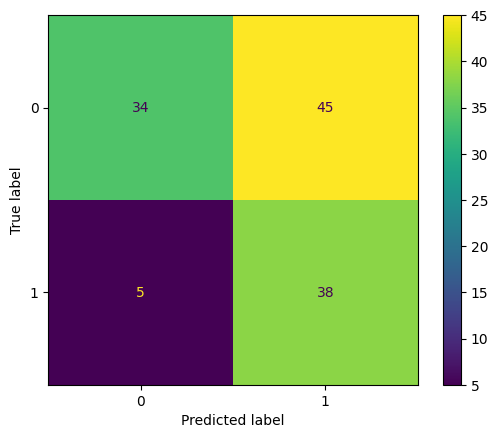

In [74]:
pred = logisticmodel.predict(x_test_sensor_static)
pred_proba = logisticmodel.predict_proba(x_test_sensor_static)
display(pred_proba[:, 1])

#visualize performance
from sklearn.metrics import auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test2, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print(classification_report(y_test2, pred))

In [76]:
#calculated performance metrics 
from sklearn.metrics import average_precision_score, auc, f1_score
sensitiviteit = cm[1,1]/(cm[1,0]+cm[1,1])
specificiteit = cm[0,0]/(cm[0,0]+cm[0,1])
ppv = cm[1,1]/(cm[1,1]+cm[0,1])
auc = roc_auc_score(y_test2, pred_proba[:, 1])
MA = logisticmodel.score(x_test_sensor_static, y_test2) #mean accuracy #het percentage wat het model goed geraden heeft 
average_precision = average_precision_score(y_test2, pred_proba[:, 1])
f1_score = f1_score(y_test2, pred)
print('sensitiviteit =', sensitiviteit, 'specificiteit =', specificiteit, 'ppv =', ppv, 'AUC =', auc, 'Mean accuracy =', MA, 'average_precision =', average_precision, 'F1_score =', f1_score)

sensitiviteit = 0.8837209302325582 specificiteit = 0.43037974683544306 ppv = 0.4578313253012048 AUC = 0.6632322637621431 Mean accuracy = 0.5901639344262295 average_precision = 0.49849089366156585 F1_score = 0.6031746031746031


Evaluate model with bootstraps

In [68]:
 #create 50 bootstraps for machine learning (different due to flattened x-values)
Bootstrap_x_sensor_flat, Bootstrap_x_static, Bootstrap_y1, Bootstrap_y2  = create_bootstraps(x_val_plus, x_Static_val, y_val, y_val2, 50)

In [69]:
#Bootstrapping, evaluate model
Bootstrap_performance = evaluate_model(logisticmodel, Bootstrap_x_sensor_flat, Bootstrap_x_static, Bootstrap_y1, Bootstrap_y2)

In [70]:
#mean and variance performance bootstrapping
Mean_performance = np.mean(Bootstrap_performance)
SD_performance = np.std(Bootstrap_performance)
df = pd.DataFrame(Bootstrap_performance, columns = ['AUC'])
# display(df)
Mean_performance, SD_performance

(0.7562856608143628, 0.0516881289562875)